In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import datetime as dt

# Fetch bond yield data from Yahoo Finance
tickers = ['^IRX', '^FVX', '^TNX', '^TYX']  # 13-week, 5-year, 10-year, 30-year treasury yield indices
data = yf.download(tickers, start='2010-01-01', end=dt.datetime.today())['Adj Close']

# Display the first few rows of the dataset
data.head()


[*********************100%%**********************]  4 of 4 completed


Ticker,^FVX,^IRX,^TNX,^TYX
Date,,,,
2010-01-04,2.652,0.055,3.841,4.660
2010-01-05,2.558,0.060,3.755,4.593
2010-01-06,2.573,0.045,3.808,4.671
2010-01-07,2.600,0.045,3.822,4.689
2010-01-08,2.566,0.040,3.808,4.695


```data``` $A$ is the feature data set, the columns are features with various terms of bonds. The matrices  $A A^T$  and  $A^T A$  share the same nonzero eigenvalues. This proposition is very powerful in the case that $m$ and $n$ are drastically different in size. For instance, if $A$ is $1000 × 4$, then there’s a quick way to find the eigenvalues
of the $1000 × 1000$ matrix $AA^T$, first find the eigenvalues of $A^TA$ (which is only 4 × 4). The other $996$ eigenvalues of $AA^T$ are all zero!

Missiong data counts Ticker
5Y     0
3M     0
10Y    0
30Y    0
dtype: int64


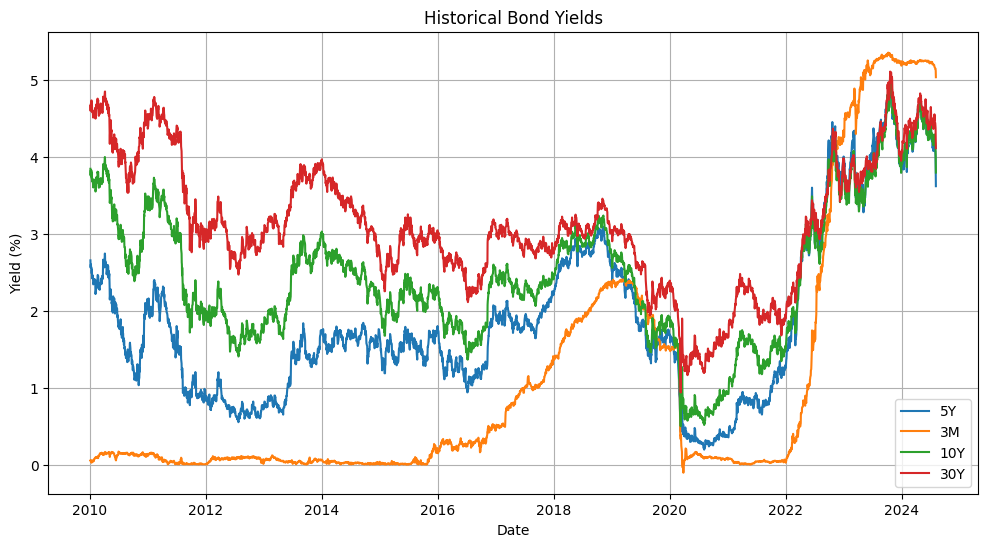

In [2]:
# Handle missing values by forward filling
data = data.rename(columns={'^IRX': '3M', '^FVX': '5Y', '^TNX': '10Y', '^TYX': '30Y'})
data = data.ffill()

# Check for any remaining missing values
print(f"Missiong data counts {data.isnull().sum()}")

# Plot the bond yields
plt.figure(figsize=(12, 6))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.title('Historical Bond Yields')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
data.cov()

Ticker,5Y,3M,10Y,30Y
Ticker,,,,
5Y,1.198537,1.591021,0.898815,0.607558
3M,1.591021,2.707019,1.034040,0.583980
10Y,0.898815,1.034040,0.821260,0.691062
30Y,0.607558,0.583980,0.691062,0.693814


We need to normalize the data, this makes sure that data with different unit or scale do not dominate.Eigenvalues and eigenvectors of the covariance matrix are used to determine the principal components in PCA.The eigenvectors provide the directions of the new feature space, and the eigenvalues indicate the importance of each direction.


In [4]:
# Standardize the data (mean = 0, variance = 1)
data_standardized = (data - data.mean()) / data.std()


Covariance matrix is diagonalized (specifically spectral decomposition as we discuss in chapter of Diagonalization)
$$
C = V \Lambda V^T
$$

 Apply the theorem, and let $ \lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_m \geq 0 $ be the eigenvalues of  $C$ with corresponding eigenvectors $v_1, v_2, ..., v_m$. 

 These eigenvectors are the _principal component_ of the data.


In [24]:
data_cov = data_standardized.cov(); data_cov


Ticker,5Y,3M,10Y,30Y
Ticker,,,,
5Y,1.000000,0.883292,0.905950,0.666255
3M,0.883292,1.000000,0.693508,0.426119
10Y,0.905950,0.693508,1.000000,0.915494
30Y,0.666255,0.426119,0.915494,1.000000


In [25]:
data_corr = data_standardized.corr(); data_corr

Ticker,5Y,3M,10Y,30Y
Ticker,,,,
5Y,1.000000,0.883292,0.905950,0.666255
3M,0.883292,1.000000,0.693508,0.426119
10Y,0.905950,0.693508,1.000000,0.915494
30Y,0.666255,0.426119,0.915494,1.000000


In [6]:
eig = np.linalg.eig(data_cov)
eigenvalues = eig[0]
eigenvectors = eig[1] # eigenvectors are not principal components, they are the directions of the principal components

A fact we will need now: _the sum of the eigenvalues is the trace of a symmetric matrix_. It can be simply proved 
$$
\operatorname{tr}(C)=\operatorname{tr}\left(P \Lambda P^{-1}\right)=\operatorname{tr}\left(P^{-1} P \Lambda\right)=\operatorname{tr}(\Lambda) 
$$
which used _cyclic property_ of trace.

The trace of covariance matrix is the sum of variances, let's compute it.

In [7]:
np.trace(data_cov)

4.0

It wouldn't surprise you, the trace equal $m$, the number of features, because we have already normalized every feature, so the variance is $1$ for each feature, and the sum of variances will be the number of features, i.e. 
$$
\text{Tr}(C) = m
$$
But also we have proved, the sum of eigenvalues should equal to the trace of a symmetric matrix, in our case a covariance matrix. Let's see if this is true.

In [8]:
np.sum(eigenvalues)

3.999999999999998

Though a bit rounding errors in computation, the sum of eigenvalues should be equal to $m$ or sum of variances.

So the each principle accounts a percentage of total variance
$$
\frac{\lambda_i}{Tr(C)}
$$

We can show the cumulative sum of ratio, the first two principal account for $98\%$ of variances, we can reduce the data's dimensionality to two dimensions (using only the first two principal components) while preserving most of the information (variance).

In [9]:
(eigenvalues / np.trace(data_cov)).cumsum()

array([0.81588776, 0.9806866 , 0.99957208, 1.        ])

Therefore we can reduce the orginal data's dimension by projecting original data onto principal components. This transformation creates a new dataset.

The transformation process is done by multiplying original data $A$ by matrix of eigenvectors $V$ 

$$
 Y = A V
$$

Now let's use sklearn library to perform the computation.

In [22]:

# Perform PCA
pca = PCA(n_components=2) # We only first two dominating principal components
principal_components = pca.fit_transform(data_standardized)


<Axes: title={'center': 'Principal Components of Bond Yields'}>

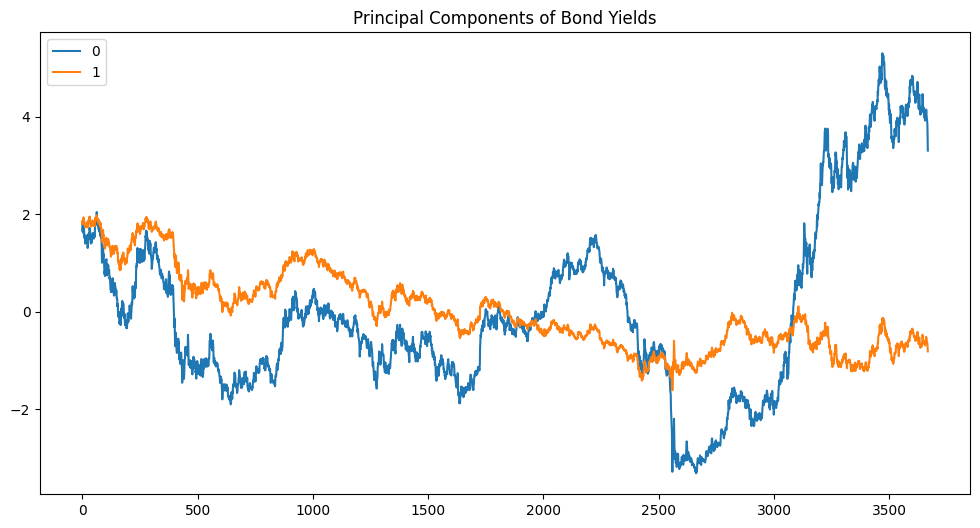

In [23]:
pd.DataFrame(principal_components).plot(
    figsize=(12, 6),
    title='Principal Components of Bond Yields'
)

In [ ]:

# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_

# Print explained variance
print("Explained Variance by Each Principal Component:")
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%}")

# Create a DataFrame with principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(data.columns))])



In [11]:
pc_df

,PC1,PC2,PC3,PC4
0,1.777713,1.849189,0.407561,0.023876
1,1.645002,1.792781,0.362196,0.026184
2,1.722953,1.871848,0.350726,0.025388
3,1.754399,1.883545,0.361040,0.016343
4,1.731460,1.894638,0.336241,0.016513
...,...,...,...,...
3663,3.964671,-0.605022,-0.403449,0.018068
3664,3.907084,-0.628706,-0.409680,0.017944
3665,3.851641,-0.653854,-0.424510,0.020909
3666,3.635627,-0.722546,-0.494864,0.026111


## PCA Loadings

We need to define PCA factor loadings before further analysis. 
$$
L = \sqrt{\Lambda}V
$$
where $\Lambda$ and $V$ are diagonal matrix with eigenvalue and matrix of eigenvector accordingly. The factoring are scaled version of matrix of eigenvectors. It represents the contribution of each original variable to the principal components. They are scaled versions of the eigenvectors, making them more interpretable in terms of the variance explained by each component.

In [15]:



# Print the factor loadings
print("Principal Factor Loadings:")
factor_loadings_df = eigenvectors * np.sqrt(eigenvalues)
print(factor_loadings_df)


Principal Factor Loadings:
[[ 0.96075306  0.21370466  0.17571138  0.02023343]
 [ 0.83116313  0.53139968 -0.16362388 -0.00307664]
 [ 0.97658592 -0.2023254   0.06585959 -0.03173145]
 [ 0.83423762 -0.53870632 -0.11643524  0.01690927]]


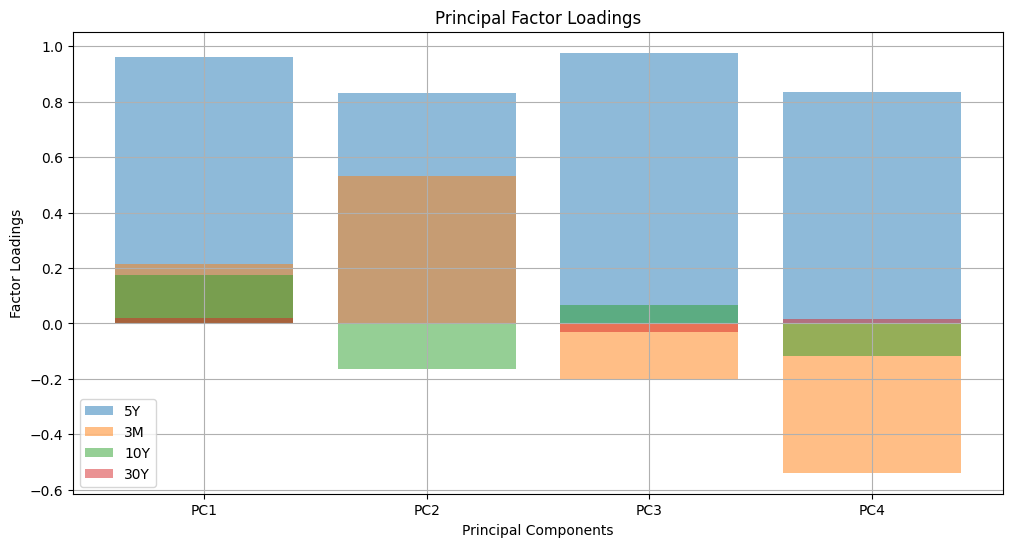

In [16]:
# Plot the factor loadings
plt.figure(figsize=(12, 6))
for i in range(len(data.columns)):
    plt.bar(range(1, len(data.columns) + 1), factor_loadings_df[:, i], alpha=0.5, align='center', label=f'{data.columns[i]}')

plt.xlabel('Principal Components')
plt.ylabel('Factor Loadings')
plt.title('Principal Factor Loadings')
plt.xticks(range(1, len(data.columns) + 1), [f'PC{i+1}' for i in range(len(data.columns))])
plt.legend(loc='best')
plt.grid(True)
plt.show()


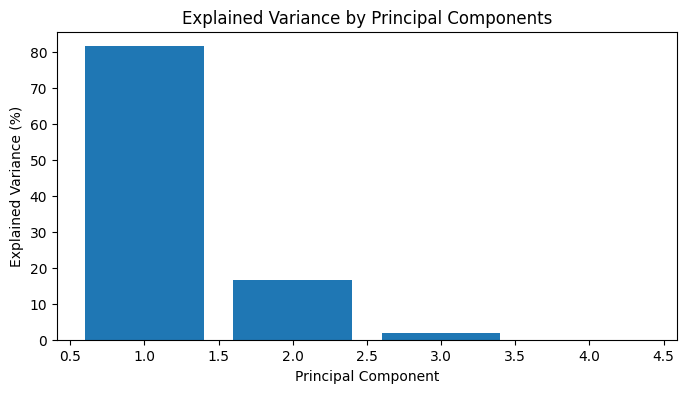

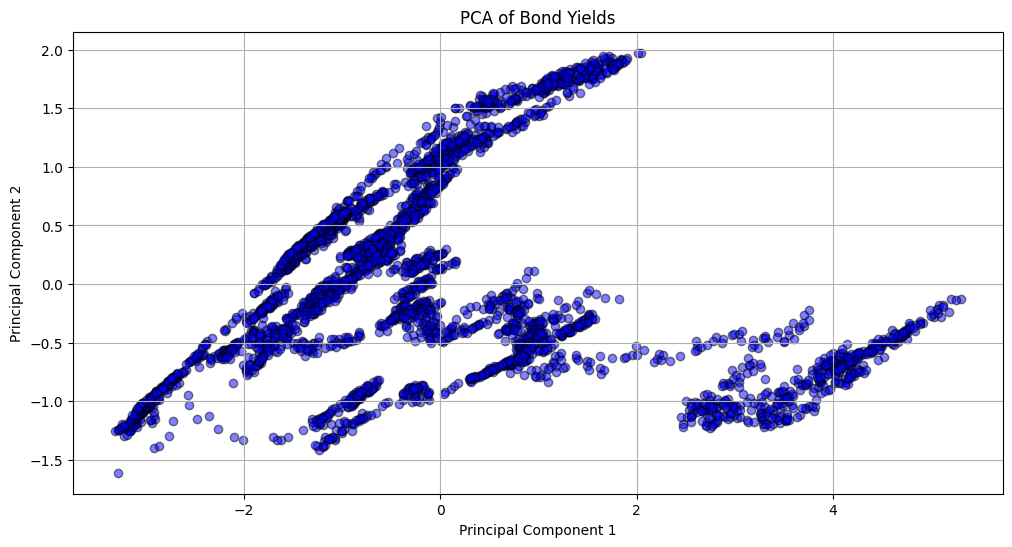

In [ ]:
# Plot explained variance
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components')
plt.show()

# Plot the first two principal components
plt.figure(figsize=(12, 6))
plt.scatter(pc_df['PC1'], pc_df['PC2'], c='blue', edgecolor='k', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Bond Yields')
plt.grid(True)
plt.show()
